## Task-1:
1) Download the cifra-100 dataset for 'coarse' label (20 superclasses) \https://www.cs.toronto.edu/~kriz/cifar.html
2) Print each label (train and test) volume as a dataframe (preparing three columns of class, train, test) \
3) Take one image from each class (20 superclasses) and plot them side-by-side in (4,5)-shape

In [19]:
import os.path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Reshape, ZeroPadding2D, Activation, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import LearningRateScheduler

### Download data

In [2]:
(x_train, y_train),(x_test, y_test) = cifar100.load_data(label_mode="coarse")

In [3]:
x_train.shape

(50000, 32, 32, 3)

In [4]:
x_test.shape

(10000, 32, 32, 3)

In [5]:
train_no = 50000*32*32
test_no = 10000*32*32

In [6]:
x_train = x_train.reshape(50000, 32, 32, 3).astype('float32')

x_test = x_test.reshape(10000, 32, 32, 3).astype('float32')

x_train/=255 #normalize data

x_test/=255 #normalize data

In [7]:
classes = ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 
           'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 
           'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 
           'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 
           'trees', 'vehicles_1', 'vehicles_2']

### Put into dataframe

In [8]:
train_arr = np.reshape(x_train, (train_no, 3))
train_df = pd.DataFrame(train_arr)
test_arr = np.reshape(x_test, (test_no, 3))
test_df = pd.DataFrame(test_arr)

In [9]:
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

### Plot unique class images

In [10]:
x_list = []
y_list = []
def unique_image(x, y):
    u, indices = np.unique(y, return_index=True)
    for number in indices:
        x_list.append(x[number])
        y_list.append(y[number])

In [11]:
unique_image(x_train, y_train)

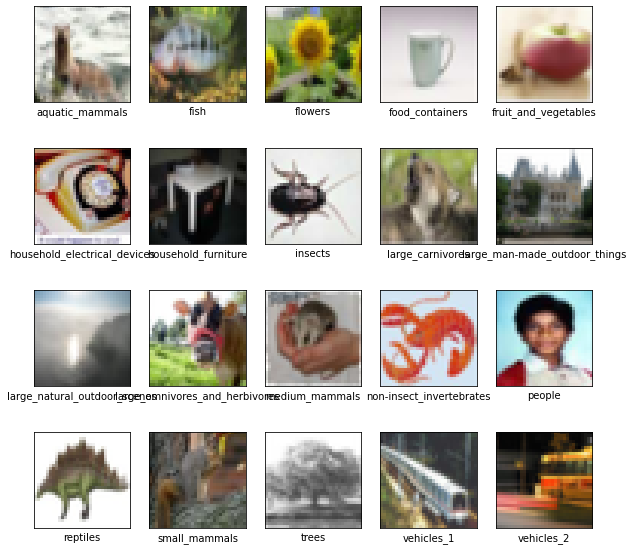

In [12]:
plt.figure(figsize=(10,10))
for image in range(0,20):
    i=image
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j=i+0
    data_plot = x_list[j]
    plt.imshow(data_plot)
    plt.xlabel(classes[y_list[j].item()])
plt.show()

## Task-2:
1) Take any computer vision architectures (e.g. VGG, ResNet, whatever you want) and find out the accuracy & f1-score.\
2) Please give your thoughts on the results

In [13]:
def build_model(x_shape, weight_decay, num_classes):
    # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.
    model = Sequential()
    weight_decay = weight_decay

    model.add(Conv2D(64, (3, 3), padding='same',
                     input_shape=x_shape, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(200, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(100, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [14]:
def predict(x, normalize=True, batch_size=50):
    if normalize:
        x = normalize_production(x)
    return model.predict(x, batch_size)

def updateEpoch(epoch, logs):
  to_save = num_epoch + epoch + 1
  report_data['acc'].append(logs['acc'])
  report_data['loss'].append(logs['loss'])
  report_data['val_acc'].append(logs['val_acc'])
  report_data['val_loss'].append(logs['val_loss'])
  with open(epoch_file, "w") as file:  
    file.write(str(to_save))
  with open(data_file, "wb") as file:
    pickle.dump(report_data, file)
  with open(all_file, "a+") as file:
    all_data = [to_save, report_data['acc'], report_data['val_acc'],
               report_data['loss'], report_data['val_loss']]
    file.write(json.dumps(all_data))
  print(epoch, logs)

In [15]:
def train(model):
    # training parameters
    batch_size = 128
    maxepoches = 100
    learning_rate = 0.1
    lr_decay = 1e-6
    lr_drop = 20


    def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))

    # data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    
        # optimization details
    sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    plot_model(model, to_file='model.png')
    
    reduce_lr = tensorflow.keras.callbacks.LearningRateScheduler(lr_scheduler)
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    lambdaCall = LambdaCallback(on_epoch_end=updateEpoch)
    callbacks_list = [reduce_lr,checkpoint,lambdaCall]

    # training process in a for loop with learning rate drop every 20 epoches.
    history = model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=x_train.shape[0] // batch_size,
        epochs=maxepoches,
        validation_data=(x_test, y_test),
        callbacks=callbacks_list,
        verbose=1)

    model.save_weights('cifar100vgg_3.h5')
    
    # summarize history for accuracy
    plt.plot(report_data['acc'])
    plt.plot(report_data['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(report_data['loss'])
    plt.plot(report_data['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return history

In [16]:
num_classes = 20
weight_decay = 0.0005
x_shape = [32, 32, 3]
train_bool = True
epoch_file="hw1_3_epoch_num.txt"
data_file="hw1_3_data.txt"
filepath="hw1_3_weights.best.hdf5"
all_file="hw1_3_all.txt"

model = build_model(x_shape, weight_decay, num_classes)

num_epoch = 0

In [17]:
if not os.path.isfile(epoch_file):
  with open(epoch_file, "w+") as file:  
    file.write(str(num_epoch))
else:
  with open(epoch_file, "r") as file:  
    num_epoch = int(file.read())

if os.path.isfile(filepath):
  model.load_weights(filepath)

if os.path.isfile(data_file):
  with open(data_file, "rb") as file:
    report_data = pickle.load(file)

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

In [20]:
report_data = {
    "acc":[],
    "val_acc":[],
    "loss":[],
    "val_loss":[]
}

if train_bool:
    history = train(model)
else:
    model.load_weights('cifar100vgg_3.h5')

predicted_x = model.predict(x_test)
residuals = np.argmax(predicted_x, 1) != np.argmax(y_test, 1)

loss = sum(residuals)/len(residuals)
print("the validation 0/1 loss is: ", loss)

/home/zapjanice/.pyenv/versions/3.8.6/envs/personal_project/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


NameError: name 'tensorflow' is not defined

## Task-3:
1) Please explain the regularization techniques used in the architecture you chose (e.g. drop-out technique, etc)\
2) Please briefly give a reason why you chose that architecture.